In [14]:
!ls ../out/softmax0-42m-2023_12_14_19_09_34

config.json                      iter_4000
iter_1000                        iter_50000
iter_16000                       iter_8000
iter_2000                        softmax0-42m-2023_12_14_19_09_34
iter_32000


In [15]:
import torch

out_dir = "../out/softmax0-42m-2023_12_14_19_09_34/iter_32000"
model = torch.load(f"{out_dir}/ckpt.pt", map_location="mps")

norms = torch.stack(
    [model["model"][key] for key in model["model"].keys() if "norm" in key], dim=0
)

norms.shape

torch.Size([17, 512])

In [16]:
norms.max(dim=1), norms.min(dim=1), norms.mean(dim=1), norms.std(dim=1)

(torch.return_types.max(
 values=tensor([0.6307, 0.4806, 0.9012, 0.6035, 0.9035, 0.7010, 0.9289, 0.7470, 0.9578,
         0.8070, 1.0149, 0.9001, 1.1604, 1.0026, 1.2452, 1.0392, 3.8818],
        device='mps:0'),
 indices=tensor([384, 166, 471, 380, 449, 188, 180, 141, 180, 131, 180, 504, 180,  53,
         180, 474,  54], device='mps:0')),
 torch.return_types.min(
 values=tensor([0.0722, 0.0718, 0.2438, 0.1458, 0.3228, 0.1955, 0.3196, 0.2088, 0.3332,
         0.2029, 0.3677, 0.1875, 0.3709, 0.2328, 0.3713, 0.3287, 0.1090],
        device='mps:0'),
 indices=tensor([376, 174, 462, 174, 417, 174, 174, 174, 174, 174, 417, 174, 174, 174,
         174, 417, 417], device='mps:0')),
 tensor([0.1377, 0.3865, 0.5242, 0.4922, 0.6240, 0.6019, 0.7343, 0.6648, 0.8242,
         0.7255, 0.8745, 0.8013, 0.9553, 0.8924, 1.0057, 0.9199, 2.1257],
        device='mps:0'),
 tensor([0.0540, 0.0415, 0.0668, 0.0493, 0.0579, 0.0530, 0.0601, 0.0524, 0.0631,
         0.0539, 0.0623, 0.0582, 0.0660, 0.0599, 0.0699

In [17]:
def find_outliers(tensor, n_sigma):
    """Count values outside n sigma (n standard deviations) in tensor."""
    # Calculate the mean and standard deviation
    mean = torch.mean(tensor)
    std_dev = torch.std(tensor)

    # Define the lower and upper bounds for values within n sigma
    lower_bound = mean - n_sigma * std_dev
    upper_bound = mean + n_sigma * std_dev

    # Count the values outside of n sigma
    mask = (tensor < lower_bound) | (tensor > upper_bound)
    outliers = tensor[mask]
    return outliers


find_outliers(norms[0], 5)

tensor([0.6307, 0.5424], device='mps:0')

In [18]:
norms[0].numel()

512

In [19]:
import matplotlib.pyplot as plt

norm_outlier_percent = [
    find_outliers(norm, 5).numel() / norm.numel() * 100 for norm in norms
]
# 5-sigma outliers exist in <1% of all RMSNorms in my Llama2 model (42M, softmax0)

norm_outlier_percent

[0.390625,
 0.78125,
 0.1953125,
 0.78125,
 0.390625,
 0.9765625,
 0.78125,
 0.9765625,
 0.5859375,
 0.9765625,
 0.5859375,
 0.9765625,
 0.78125,
 0.9765625,
 0.5859375,
 0.5859375,
 0.9765625]

In [20]:
model["model"].keys()

odict_keys(['tok_embeddings.weight', 'layers.0.attention.mask', 'layers.0.attention.wq.weight', 'layers.0.attention.wk.weight', 'layers.0.attention.wv.weight', 'layers.0.attention.wo.weight', 'layers.0.feed_forward.w1.weight', 'layers.0.feed_forward.w2.weight', 'layers.0.feed_forward.w3.weight', 'layers.0.attention_norm.weight', 'layers.0.ffn_norm.weight', 'layers.1.attention.mask', 'layers.1.attention.wq.weight', 'layers.1.attention.wk.weight', 'layers.1.attention.wv.weight', 'layers.1.attention.wo.weight', 'layers.1.feed_forward.w1.weight', 'layers.1.feed_forward.w2.weight', 'layers.1.feed_forward.w3.weight', 'layers.1.attention_norm.weight', 'layers.1.ffn_norm.weight', 'layers.2.attention.mask', 'layers.2.attention.wq.weight', 'layers.2.attention.wk.weight', 'layers.2.attention.wv.weight', 'layers.2.attention.wo.weight', 'layers.2.feed_forward.w1.weight', 'layers.2.feed_forward.w2.weight', 'layers.2.feed_forward.w3.weight', 'layers.2.attention_norm.weight', 'layers.2.ffn_norm.weight

In [21]:
attns = torch.stack(
    [model["model"][key] for key in model["model"].keys() if "attention.w" in key],
    dim=0,
)

attns.shape  # layer, channel, seq

torch.Size([32, 512, 512])

In [22]:
attn_outlier_percent = [
    find_outliers(attn, 6).numel() / attn.numel() * 100 for attn in attns
]
# But 5-sigma outlier even fewer in attn weights -- almost <0.05%.

attn_outlier_percent

[0.0827789306640625,
 0.01678466796875,
 0.0,
 0.0331878662109375,
 0.020599365234375,
 0.0274658203125,
 0.0003814697265625,
 0.01373291015625,
 0.0087738037109375,
 0.0263214111328125,
 0.0,
 0.0064849853515625,
 0.0072479248046875,
 0.0225067138671875,
 0.0,
 0.0030517578125,
 0.008392333984375,
 0.0152587890625,
 0.0,
 0.00457763671875,
 0.006866455078125,
 0.0148773193359375,
 0.0,
 0.002288818359375,
 0.006103515625,
 0.016021728515625,
 0.0,
 0.005340576171875,
 0.0041961669921875,
 0.014495849609375,
 0.0,
 0.0125885009765625]

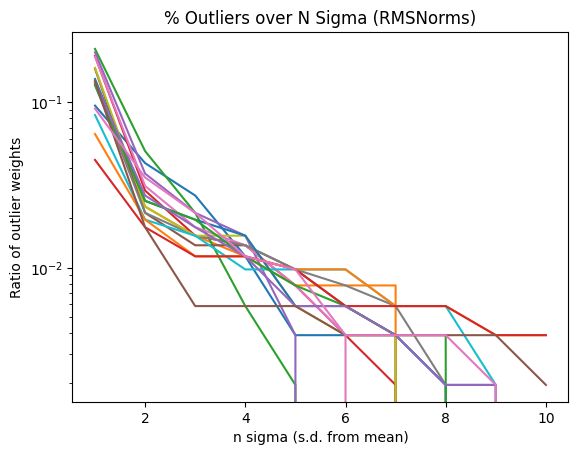

In [23]:
# So attn weights dropped exponentially low with n sigma. What about norms?
total_n = 10
x = list(range(1, total_n + 1))

for norm in norms:
    norm_outlier_percent = [find_outliers(norm, n).numel() / norm.numel() for n in x]
    plt.plot(x, norm_outlier_percent)

plt.yscale("log")
plt.ylabel("Ratio of outlier weights")
plt.xlabel("n sigma (s.d. from mean)")
plt.title("% Outliers over N Sigma (RMSNorms)")
plt.show()

# Wow strong outlier weights remain in norms even at 10 sigma (0.1%)

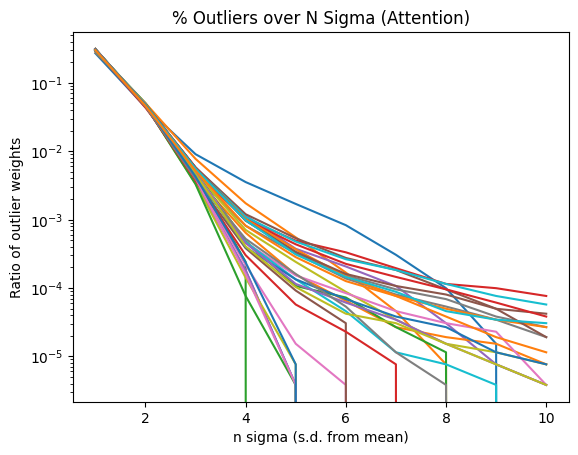

In [24]:
# What happens when we vary n sigma?
total_n = 10
x = list(range(1, total_n + 1))

for attn in attns:
    attn_outlier_percent = [find_outliers(attn, n).numel() / attn.numel() for n in x]
    plt.plot(x, attn_outlier_percent)

plt.yscale("log")
plt.ylabel("Ratio of outlier weights")
plt.xlabel("n sigma (s.d. from mean)")
plt.title("% Outliers over N Sigma (Attention)")
plt.show()

In [25]:
ffnns = torch.stack(
    [
        model["model"][key].flatten()
        for key in model["model"].keys()
        if "feed_forward.w" in key
    ],
    dim=0,
)
ffnns.shape

torch.Size([24, 704512])

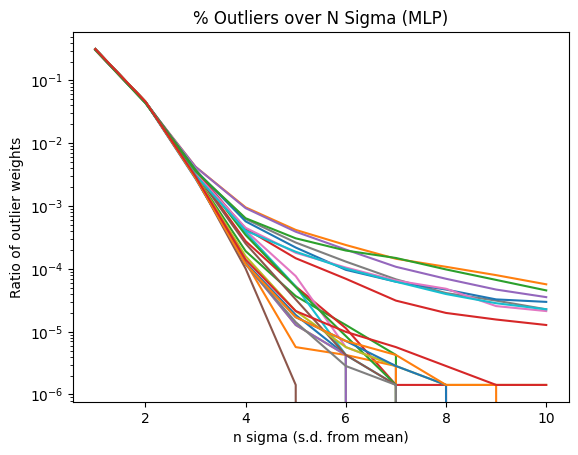

In [26]:
total_n = 10
x = list(range(1, total_n + 1))

for ff in ffnns:
    norm_outlier_percent = [find_outliers(ff, n).numel() / ff.numel() for n in x]
    plt.plot(x, norm_outlier_percent)

plt.yscale("log")
plt.ylabel("Ratio of outlier weights")
plt.xlabel("n sigma (s.d. from mean)")
plt.title("% Outliers over N Sigma (MLP)")
plt.show()

# MLPs also drop exponentially over n. Most gone by 5 sigma, rest not as incrimminating (<0.01%).